# MNIST Prediction with Artificial Neural Network

- MNIST dataset: is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. More info can be found at the [MNIST homepage](http://yann.lecun.com/exdb/mnist/).
- Goal: build a simple artificial neural network to predict the digit in the images.
- Reference: [Oddly Satisfying Deep Learning](https://pythonandml.github.io/dlbook/content/convolutional_neural_networks/cnn_over_mlp.html)

#### Import libraries

In [247]:
# for linear algebra
import numpy as np

# for plotting data, loss, accuracy
import matplotlib.pyplot as plt

# loading mnist dataset from keras
from keras import datasets

# show progress bar
from tqdm import tqdm

# for type hinting
from typing import Optional

## 1. Utility Functions

1. **plot_data**: plot the random 8 images from the dataset.
2. **Activation Functions**: Linear, reLU, Sigmoid, Tanh, Softmax.
3. **Weight Initialization**: Zeros, Ones, Random, Random Uniform.
4. **Optimization Functions**: Gradient Descent, Stochastic Gradient Descent, RMSprop, Adam.

### 1.1. Plotting Functions

In [248]:
def plot_data(
    X: np.ndarray, y: np.ndarray, y_proba: Optional[np.ndarray] = None
) -> None:
    nrows, ncols = 2, 4
    _, axes = plt.subplots(nrows, ncols, figsize=(8, 4))

    len_x = X.shape[0]
    for idx in range(nrows * ncols):
        ax = axes[idx // ncols, idx % ncols]

        img_idx = np.random.randint(0, len_x)

        ax.imshow(X[img_idx], cmap="gray")
        ax.set(xticks=[], yticks=[])

        true_label = f"True: {y[img_idx]}"

        if y_proba is not None:
            pred_label = f"Pred: {y_proba[img_idx]}"

        img_title = true_label if y_proba is None else f"{true_label}\n{pred_label}"
        ax.set_xlabel(img_title)

    plt.tight_layout()
    plt.show()

### 1.2. Activation Functions and Their Derivatives class

- Sigmoid function: $\sigma(z) = \frac{1}{1 + e^{-z}}$
- Derivative of sigmoid function: $\sigma'(z) = \sigma(z)(1 - \sigma(z))$

- ReLU function: $f(z) = \max(0, z)$
- Derivative of ReLU function: $f'(z) = 0$ if $z < 0$ and $f'(z) = 1$ if $z \geq 0$

- Tanh function: $\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$
- Derivative of tanh function: $\tanh'(z) = 1 - \tanh^2(z)$

- Softmax function: $S(z)_j = \frac{e^{z_j}}{\sum_{k=1}^{K} e^{z_k}}$ for $j = 1, 2, \ldots, K$
- Derivative of softmax function: $\frac{\partial S(z)_j}{\partial z_i} = S(z)_j(\delta_{ij} - S(z)_i)$

In [249]:
class Activation:
    def __init__(self, act: str = None) -> None:
        if act is None:
            self.act = "relu"
        else:
            self.act = act

    def linear(self, x: np.ndarray) -> np.ndarray:
        return x

    def d_linear(self, x: np.ndarray) -> np.ndarray:
        return np.ones(x.shape)

    def reLU(self, x: np.ndarray) -> np.ndarray:
        return x * (x > 0)

    def d_reLU(self, x: np.ndarray) -> np.ndarray:
        return (x > 0) * np.ones(x.shape)

    def sigmoid(self, x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x))

    def d_sigmoid(self, x: np.ndarray) -> np.ndarray:
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def tanh(self, x: np.ndarray) -> np.ndarray:
        return np.tanh(x)

    def d_tanh(self, x: np.ndarray) -> np.ndarray:
        return 1 - self.tanh(x) ** 2

    def softmax(self, x: np.ndarray) -> np.ndarray:
        z = x - np.max(x, axis=-1, keepdims=True)
        numerator = np.exp(z)
        denominator = np.sum(numerator, axis=-1, keepdims=True)
        softmax = numerator / denominator
        return softmax

    def d_softmax(self, x: np.ndarray) -> np.ndarray:
        if len(x.shape) == 1:
            x = np.array(x).reshape(1, -1)
        else:
            x = np.array(x)
        m, d = x.shape
        a = self.softmax(x)
        tensor1 = np.einsum("ij,ik->ijk", a, a)
        tensor2 = np.einsum("ij,jk->ijk", a, np.eye(d, d))
        return tensor2 - tensor1

    def get_activation(self, X: np.ndarray) -> np.ndarray:
        if self.act == "linear":
            return self.linear(X)
        elif self.act == "sigmoid":
            return self.sigmoid(X)
        elif self.act == "tanh":
            return self.tanh(X)
        elif self.act == "reLU":
            return self.reLU(X)
        elif self.act == "softmax":
            return self.softmax(X)
        else:
            raise ValueError("Activation function not recognized")

    def get_d_activation(self, X: np.ndarray) -> np.ndarray:
        if self.act == "linear":
            return self.d_linear(X)
        elif self.act == "sigmoid":
            return self.d_sigmoid(X)
        elif self.act == "tanh":
            return self.d_tanh(X)
        elif self.act == "reLU":
            return self.d_reLU(X)
        elif self.act == "softmax":
            return self.d_softmax(X)
        else:
            raise ValueError("Activation function not recognized")

    def forward(self, X: np.ndarray) -> np.ndarray:
        self.X = X
        z = self.get_activation(X)
        return z

    def backpropagation(self, dZ: np.ndarray) -> np.ndarray:
        dA = dZ * self.get_d_activation(self.X)
        if self.activation_type == "softmax":
            dX = np.einsum("ijk,ik->ij", dA, dZ)
        else:
            dX = dA * dZ
        return dX

### 1.3. Weight Initialization class

- Zeros initialization: $w = np.zeros(shape)$
- Ones initialization: $w = np.ones(shape)$
- Random initialization: $w = np.random.randn(shape)$
- Random uniform initialization: $w = np.random.uniform(size=shape)$

In [250]:
class WeightInitializer:
    def __init__(self, shape, init: str = None, seed: int = None) -> None:
        """
        :param shape: shape of the weight matrix
        :param init: type of initialization (available initializations: zeros, ones, random, random_uniform)
        :param seed: seed for random initialization
        """
        self.shape = shape

        if init is None:
            self.init = "random"
        else:
            self.init = init

        if seed is None:
            self.seed = 69
        else:
            self.seed = seed

    def zeros(self) -> np.ndarray:
        return np.zeros(self.shape)

    def ones(self) -> np.ndarray:
        return np.ones(self.shape)

    def random(self) -> np.ndarray:
        np.random.seed(self.seed)
        return np.random.randn(*self.shape)

    def random_uniform(self) -> np.ndarray:
        np.random.seed(self.seed)
        return np.random.uniform(size=self.shape)

    def get_initializer(self) -> np.ndarray:
        if self.init == "zeros":
            return self.zeros()
        elif self.init == "ones":
            return self.ones()
        elif self.init == "random":
            return self.random()
        elif self.init == "random_uniform":
            return self.random_uniform()
        else:
            raise ValueError(
                "Valid initializations are: zeros, ones, random, random_uniform"
            )

### 1.4.  Optimizers class

- Gradient Descent Optimizer: $w = w - \alpha \nabla_w L(w)$
- Stochastic Gradient Descent Optimizer: $w = w - \alpha \nabla_w L(w)$
- RMSprop Optimizer: $v = \beta v + (1 - \beta) \nabla_w L(w) \odot \nabla_w L(w)$ and $w = w - \alpha \frac{\nabla_w L(w)}{\sqrt{v + \epsilon}}$
- Adam Optimizer: $m = \beta_1 m + (1 - \beta_1) \nabla_w L(w)$, $v = \beta_2 v + (1 - \beta_2) \nabla_w L(w) \odot \nabla_w L(w)$, $m_{\text{corrected}} = \frac{m}{1 - \beta_1^t}$, $v_{\text{corrected}} = \frac{v}{1 - \beta_2^t}$, and $w = w - \alpha \frac{m_{\text{corrected}}}{\sqrt{v_{\text{corrected}} + \epsilon}}$

> Note: Actually, i only use the Gradient Descent Optimizer in this notebook.

In [251]:
class Optimizer:
    def __init__(
        self,
        op_type: str = None,
        shape_W: tuple[int, int] = None,
        shape_b: tuple[int, int] = None,
        m1: float = 0.9,
        m2: float = 0.999,
        epsilon: int = 1e-8,
    ) -> None:
        """
        :param op_type: type of optimizer (available optimizers: GD, SGD, RMSProp, Adam)
        :param shape_W: shape of the weight matrix
        :param shape_b: shape of the bias matrix
        :param m1: hyperparameter >= 0 that accelerates gradient descent in the relevant direction and dampens oscillations. Used in RMSprop
        :param m2: hyperparameter for adam only
        :param epsilon: parameter used in adam and RMSprop to prevent division by zero error
        """
        if op_type is None:
            self.op_type = "GD"
        else:
            self.op_type = op_type

        self.m1 = m1
        self.m2 = m2
        self.epsilon = epsilon

        self.vdW = np.zeros(shape_W)
        self.vdb = np.zeros(shape_b)

        self.SdW = np.zeros(shape_W)
        self.Sdb = np.zeros(shape_b)

    def GD(self, dW: np.ndarray, db: np.ndarray, _: int) -> tuple:
        """
        :param dW: gradient of Weight W for iteration k
        :param db: gradient of bias b for iteration k
        :param k: iteration number
        """
        return dW, db

    def SGD(self, dW: np.ndarray, db: np.ndarray, _: int) -> tuple:
        """
        :param dW: gradient of Weight W for iteration k
        :param db: gradient of bias b for iteration k
        :param k: iteration number
        """
        self.vdW = self.momentum1 * self.vdW + (1 - self.momentum1) * dW
        self.vdb = self.momentum1 * self.vdb + (1 - self.momentum1) * db

        return self.vdW, self.vdb

    def RMSProp(self, dW: np.ndarray, db: np.ndarray, _: int) -> tuple:
        """
        :param dW: gradient of Weight W for iteration k
        :param db: gradient of bias b for iteration k
        :param k: iteration number
        """
        self.SdW = self.momentum2 * self.SdW + (1 - self.momentum2) * (dW**2)
        self.Sdb = self.momentum2 * self.Sdb + (1 - self.momentum2) * (db**2)

        den_W = np.sqrt(self.SdW) + self.epsilon
        den_b = np.sqrt(self.Sdb) + self.epsilon

        return dW / den_W, db / den_b

    def Adam(self, dW: np.ndarray, db: np.ndarray, k: int) -> tuple:
        """
        :param dW: gradient of Weight W for iteration k
        :param db: gradient of bias b for iteration k
        :param k: iteration number
        """
        # momentum
        self.vdW = self.momentum1 * self.vdW + (1 - self.momentum1) * dW
        self.vdb = self.momentum1 * self.vdb + (1 - self.momentum1) * db

        # rmsprop
        self.SdW = self.momentum2 * self.SdW + (1 - self.momentum2) * (dW**2)
        self.Sdb = self.momentum2 * self.Sdb + (1 - self.momentum2) * (db**2)

        # correction
        if k > 1:
            vdW_h = self.vdW / (1 - (self.momentum1**k))
            vdb_h = self.vdb / (1 - (self.momentum1**k))
            SdW_h = self.SdW / (1 - (self.momentum2**k))
            Sdb_h = self.Sdb / (1 - (self.momentum2**k))
        else:
            vdW_h = self.vdW
            vdb_h = self.vdb
            SdW_h = self.SdW
            Sdb_h = self.Sdb

        den_W = np.sqrt(SdW_h) + self.epsilon
        den_b = np.sqrt(Sdb_h) + self.epsilon

        return vdW_h / den_W, vdb_h / den_b

    def get_optimizer(self, dW: np.ndarray, db: np.ndarray, k: int) -> tuple:
        if self.op_type == "GD":
            return self.GD(dW, db, k)
        elif self.op_type == "SGD":
            return self.SGD(dW, db, k)
        elif self.op_type == "RMSProp":
            return self.RMSProp(dW, db, k)
        elif self.op_type == "Adam":
            return self.Adam(dW, db, k)
        else:
            raise ValueError("Valid optiomizers are GD, SGD, RMSProp, Adam")

## 2. Load Data

- Load the MNIST dataset from the `keras.datasets.mnist` module.
- Split the dataset into training and testing sets.

In [253]:
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

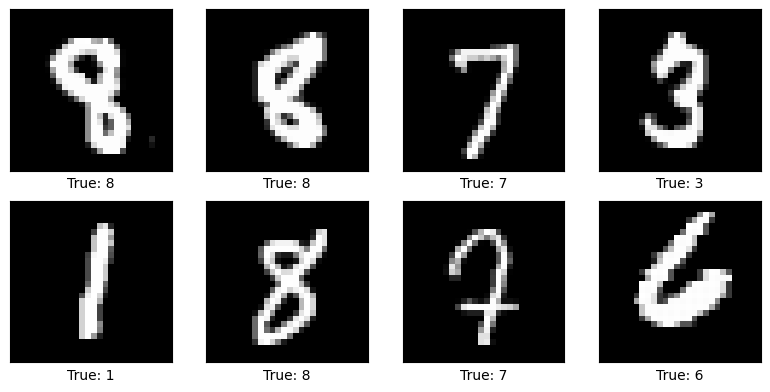

In [254]:
plot_data(X_train, y_train)

## 3. Image Preprocessing

- Normalize the images by dividing each pixel by 255.
- Add channel dimension to the images.
- Convert y to one-hot encoding.

In [255]:
# Convert to float32 and scale to [0, 1]
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

In [256]:
# Add channel dimension
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [257]:
print("x_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

x_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


In [258]:
"""Conver y to one-hot encoding. Example:
y = 2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
"""

y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

In [259]:
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (60000, 10)
y_test shape: (10000, 10)


## 4. Artificial Neural Network

### 4.1. With Convolutional Neural Network

#### 4.1.1. Dense Layer

THis class implements the operations:
- Forward: 
    1. $Z = XW + B^T$
    2. $A = f(Z)$
- Backward: $dX = dZ W^T$, $dW = X^T dZ$, and $dB = \sum_{i=1}^{m} dZ_i$

In [260]:
class Dense:
    def __init__(
        self,
        neurons: int,
        act: str = None,
        use_bias: bool = True,
        weight_type: str = None,
        weight_regularizer: tuple = None,
        seed: int = None,
        inp_dim: int = None,
    ) -> None:
        """
        :param neurons: Number of neurons in the layer
        :param act: Activation function to use (linear, sigmoid, tanh, reLU, softmax)
        :param use_bias: Whether to use bias
        :param weight_type: Type of weight initialization
        :param weight_regularizer: Regularization term for the weights
        :param seed: Seed for random initialization
        :param inp_dim: Input dimension for the layer
        """
        self.neurons = neurons
        self.act = Activation(act=act)
        self.use_bias = use_bias
        self.weight_initializer = weight_type

        if weight_regularizer is not None:
            self.weight_regularizer = weight_regularizer
        else:
            self.weight_regularizer = ("L2", 0)

        self.seed = seed
        self.inp_dim = inp_dim

    def initialize(self, hl: int, op_type: str) -> None:
        """
        :param hl: Number of neurons in the previous layer
        :param op_type: Type of optimizer to use (GD, SGD, RMSProp, Adam)
        """
        shape_W = (hl, self.neurons)
        shape_b = (self.neurons, 1)
        initializer = WeightInitializer(
            shape=shape_W, init=self.weight_initializer, seed=self.seed
        )
        self.W = initializer.get_initializer()
        self.b = np.zeros(shape_b)

        self.optimizer = Optimizer(op_type=op_type, shape_W=shape_W, shape_b=shape_b)

    def forward(self, X: np.ndarray) -> np.ndarray:
        self.X = X
        self.net = X @ self.W + self.b.T
        return self.act.forward(self.net)

    def backpropagation(self, dA: np.ndarray) -> np.ndarray:
        dZ = self.act.backpropagation(dA)
        dR = dZ.copy()

        self.dB: np.ndarray = np.sum(dZ, axis=0).reshape(-1, 1)
        self.dW: np.ndarray = self.X.T @ dR
        dX = dR @ self.W.T

        return dX

    def update(self, lr: float, b: int, k: int) -> None:
        """
        :param lr: Learning rate for the optimizer
        :param b: Batch size (sumble of samples in batch)
        :param k: Iteration number
        """
        dW, db = self.optimizer.get_optimizer(self.dW, self.dB, k)

        if self.weight_regularizer[0].lower() == "l2":
            dW += self.weight_regularizer[1] * self.W
        elif self.weight_regularizer[0].lower() == "l1":
            dW += self.weight_regularizer[1] * np.sign(self.W)

        self.W -= dW * (lr / b)
        if self.use_bias:
            self.b -= db * (lr / b)

#### 4.1.2. Dropout Layer
This class will perform forward and backward propagation for a dropout layer.

In [261]:
class Dropout:
    def __init__(self, p: int) -> None:
        """
        :param p: Probability of dropout
        """
        self.p = p
        if self.p == 0:
            self.p += 1e-6
        if self.p == 1:
            self.p -= 1e-6

    def forward(self, X: np.ndarray) -> np.ndarray:
        self.mask = (np.random.rand(*X.shape) < self.p) / self.p
        return X * self.mask

    def backpropagation(self, dZ: np.ndarray) -> np.ndarray:
        return dZ * self.mask

#### 4.1.3. Batch Normalization class


In [262]:
class BatchNormalization:
    def __init__(self, momentum: float = 0.9, epsilon: float = 1e-6) -> None:
        """
        :param momentum: Momentum for the moving average
        :param epsilon:  Small value to prevent division by zero
        """
        self.momentum = momentum
        self.epsilon = epsilon

    def initialize(self, shape: tuple) -> None:
        """
        :param shape: Shape of the input to BN layer
        """
        self.gamma = np.ones(shape)
        self.beta = np.zeros(shape)
        self.moving_mean = np.zeros(shape)
        self.moving_var = np.zeros(shape)

    def forward(self, z: np.ndarray, mode: str = "train"):
        """
        :param z: Input to the batch normalization layer
        :param mode: Mode of operation (train or test)
        """

        if mode == "train":
            self.m, self.d = z.shape
            self.mu = np.mean(z, axis=0)  # 𝜇
            self.var = np.var(z, axis=0)  # 𝜎^2
            self.zmu = z - self.mu  # z - 𝜇
            self.ivar = 1 / np.sqrt(self.var + self.epsilon)  # 1 / √(𝜎^2 + ε)
            self.zhat = self.zmu * self.ivar  # z~ = (z - 𝜇) / √(𝜎^2 + ε)
            q = self.gamma * self.zhat + self.beta  # q = γz~ + β
            self.running_mean = (
                self.momentum * self.moving_mean + (1 - self.momentum) * self.mu
            )
            self.running_var = (
                self.momentum * self.moving_var + (1 - self.momentum) * self.var
            )
        elif mode == "test":
            q = (z - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
            q = self.gamma * q + self.beta
        else:
            raise ValueError("Valid modes are train and test")
        return q

    def backpropagation(self, dQ: np.ndarray) -> np.ndarray:
        self.dGamma = np.sum(dQ * self.zhat, axis=0)
        self.dBeta = np.sum(dQ, axis=0)
        dZhat = dQ * self.gamma
        dVar = np.sum(dZhat * self.zmu * (-0.5) * (self.ivar**3), axis=0)
        dMu = np.sum(dZhat * -self.ivar, axis=0)
        dZ = dZhat * self.ivar + dVar * (2 * self.m) * self.zmu + (1 / self.m) * dMu
        return dZ

    def update(self, lr: float, m: int, k: int) -> None:
        """
        :param lr: Learning rate for the optimizer
        :param m: Batch size (sumble of samples in batch)
        :param k: Iteration number
        """
        self.gamma -= self.dGamma * (lr / m)
        self.beta -= self.dBeta * (lr / m)

#### 4.1.4. Padding class

In [263]:
class Padding2D:

    def __init__(self, p="valid"):
        """
        :param p: padding type (valid, same, int, tuple)
        """
        self.p = p

    def get_dimensions(self, input_shape, kernel_size, s=(1, 1)):
        """
        Utility function to help get the dimension of the output after padding
        """
        if len(input_shape) == 4:
            m, Nc, Nh, Nw = input_shape
        elif len(input_shape) == 3:
            Nc, Nh, Nw = input_shape

        Kh, Kw = kernel_size
        sh, sw = s
        p = self.p

        if type(p) == tuple:
            ph, pw = p
            pt, pb = ph // 2, (ph + 1) // 2
            pl, pr = pw // 2, (pw + 1) // 2

        elif p == "valid":
            pt, pb = 0, 0
            pl, pr = 0, 0

        elif p == "same":
            ph = (sh - 1) * Nh + Kh - sh
            pw = (sw - 1) * Nw + Kw - sw

            pt, pb = ph // 2, (ph + 1) // 2
            pl, pr = pw // 2, (pw + 1) // 2

        else:
            raise ValueError(
                "Incorrect padding type. Allowed types are only 'same', 'valid', an integer or a tuple of length 2."
            )

        if len(input_shape) == 4:
            output_shape = (m, Nc, Nh + pt + pb, Nw + pl + pr)
        elif len(input_shape) == 3:
            output_shape = (Nc, Nh + pt + pb, Nw + pl + pr)

        return output_shape, (pt, pb, pl, pr)

    def forward(self, X: np.ndarray, kernel_size: int, s: tuple = (1, 1)):
        """
        :param X: input to the padding layer
        :param kernel_size: size of the kernel
        :param s: stride
        """
        self.input_shape = X.shape
        m, Nc, Nh, Nw = self.input_shape

        self.output_shape, (self.pt, self.pb, self.pl, self.pr) = self.get_dimensions(
            self.input_shape, kernel_size, s=s
        )

        zeros_r = np.zeros((m, Nc, Nh, self.pr))
        zeros_l = np.zeros((m, Nc, Nh, self.pl))
        zeros_t = np.zeros((m, Nc, self.pt, Nw + self.pl + self.pr))
        zeros_b = np.zeros((m, Nc, self.pb, Nw + self.pl + self.pr))

        Xp = np.concatenate((X, zeros_r), axis=3)
        Xp = np.concatenate((zeros_l, Xp), axis=3)
        Xp = np.concatenate((zeros_t, Xp), axis=2)
        Xp = np.concatenate((Xp, zeros_b), axis=2)

        return Xp

    def backpropagation(self, dXp: np.ndarray):
        """
        :param dXp: gradient of the output of the padding layer
        """
        _, _, Nh, Nw = self.input_shape
        dX = dXp[:, :, self.pt : self.pt + Nh, self.pl : self.pl + Nw]
        return dX

#### 4.1.5. Convolutional Layer class

#### 4.1.6. Max Pooling Layer class

In [264]:
class Pooling2D:

    def __init__(self, pool_size=(2, 2), s=(2, 2), p="valid", pool_type="max"):
        """
        Parameters:

        pool_size: An integer or tuple/list of 2 integers,
                     specifying the height and width of the 2D convolution window.

        s: strides along height and width (sh, sw)

        p: padding type
           Allowed types are only 'same', 'valid', an integer or a tuple of length 2.

        pool_type: pooling type
        Allowed types are only 'max', or 'mean'
        """
        self.padding = Padding2D(p=p)

        if type(pool_size) == int:
            self.pool_size = (pool_size, pool_size)
        elif type(pool_size) == tuple and len(pool_size) == 2:
            self.pool_size = pool_size

        self.Kh, self.Kw = self.pool_size

        if type(s) == int:
            self.s = (s, s)
        elif type(s) == tuple and len(s) == 2:
            self.s = s

        self.sh, self.sw = self.s

        self.pool_type = pool_type

    def get_dimensions(self, input_shape):

        if len(input_shape) == 4:
            m, Nc, Nh, Nw = input_shape
        elif len(input_shape) == 3:
            Nc, Nh, Nw = input_shape

        Oh = (Nh - self.Kh) // self.sh + 1
        Ow = (Nw - self.Kw) // self.sw + 1

        if len(input_shape) == 4:
            self.output_shape = (m, Nc, Oh, Ow)
        elif len(input_shape) == 3:
            self.output_shape = (Nc, Oh, Ow)

    def prepare_subMatrix(self, X, pool_size, s):
        m, Nc, Nh, Nw = X.shape
        sh, sw = s
        Kh, Kw = pool_size

        Oh = (Nh - Kh) // sh + 1
        Ow = (Nw - Kw) // sw + 1

        strides = (Nc * Nh * Nw, Nh * Nw, Nw * sh, sw, Nw, 1)
        strides = tuple(i * X.itemsize for i in strides)

        subM = np.lib.stride_tricks.as_strided(
            X, shape=(m, Nc, Oh, Ow, Kh, Kw), strides=strides
        )
        return subM

    def pooling(self, X, pool_size=(2, 2), s=(2, 2)):

        subM = self.prepare_subMatrix(X, pool_size, s)

        if self.pool_type == "max":
            return np.max(subM, axis=(-2, -1))
        elif self.pool_type == "mean":
            return np.mean(subM, axis=(-2, -1))
        else:
            raise ValueError("Allowed pool types are only 'max' or 'mean'.")

    def prepare_mask(self, subM, Kh, Kw):

        m, Nc, Oh, Ow, Kh, Kw = subM.shape

        a = subM.reshape(-1, Kh * Kw)
        idx = np.argmax(a, axis=1)
        b = np.zeros(a.shape)
        b[np.arange(b.shape[0]), idx] = 1
        mask = b.reshape((m, Nc, Oh, Ow, Kh, Kw))

        return mask

    def mask_dXp(self, mask, Xp, dZ, Kh, Kw):
        dA = np.einsum("i,ijk->ijk", dZ.reshape(-1), mask.reshape(-1, Kh, Kw)).reshape(
            mask.shape
        )
        m, Nc, Nh, Nw = Xp.shape
        strides = (Nc * Nh * Nw, Nh * Nw, Nw, 1)
        strides = tuple(i * Xp.itemsize for i in strides)
        dXp = np.lib.stride_tricks.as_strided(dA, Xp.shape, strides)
        return dXp

    def maxpool_backprop(self, dZ, X):

        Xp = self.padding.forward(X, self.pool_size, self.s)

        subM = self.prepare_subMatrix(Xp, self.pool_size, self.s)

        m, Nc, Oh, Ow, Kh, Kw = subM.shape

        m, Nc, Nh, Nw = Xp.shape

        mask = self.prepare_mask(subM, Kh, Kw)

        dXp = self.mask_dXp(mask, Xp, dZ, Kh, Kw)

        return dXp

    def dZ_dZp(self, dZ):
        sh, sw = self.s
        Kh, Kw = self.pool_size

        dZp = np.kron(
            dZ, np.ones((Kh, Kw), dtype=dZ.dtype)
        )  # similar to repelem in matlab

        jh, jw = Kh - sh, Kw - sw  # jump along height and width

        if jw != 0:
            L = dZp.shape[-1] - 1

            l1 = np.arange(sw, L)
            l2 = np.arange(sw + jw, L + jw)

            mask = np.tile([True] * jw + [False] * jw, len(l1) // jw).astype(bool)

            r1 = l1[mask[: len(l1)]]
            r2 = l2[mask[: len(l2)]]

            dZp[:, :, :, r1] += dZp[:, :, :, r2]
            dZp = np.delete(dZp, r2, axis=-1)

        if jh != 0:
            L = dZp.shape[-2] - 1

            l1 = np.arange(sh, L)
            l2 = np.arange(sh + jh, L + jh)

            mask = np.tile([True] * jh + [False] * jh, len(l1) // jh).astype(bool)

            r1 = l1[mask[: len(l1)]]
            r2 = l2[mask[: len(l2)]]

            dZp[:, :, r1, :] += dZp[:, :, r2, :]
            dZp = np.delete(dZp, r2, axis=-2)

        return dZp

    def averagepool_backprop(self, dZ, X):

        Xp = self.padding.forward(X, self.pool_size, self.s)

        m, Nc, Nh, Nw = Xp.shape

        dZp = self.dZ_dZp(dZ)

        ph = Nh - dZp.shape[-2]
        pw = Nw - dZp.shape[-1]

        padding_back = Padding2D(p=(ph, pw))

        dXp = padding_back.forward(dZp, s=self.s, kernel_size=self.pool_size)

        return dXp / (Nh * Nw)

    def forward(self, X):
        """
        Parameters:

        X: input of shape (m, Nc, Nh, Nw)

        Returns:

        Z: pooled X
        """

        self.X = X

        # padding
        Xp = self.padding.forward(X, self.pool_size, self.s)

        Z = self.pooling(Xp, self.pool_size, self.s)

        return Z

    def backpropagation(self, dZ):
        """
        Parameters:

        dZ: Output Error

        Return:

        dX: Backprop Error of X
        """
        if self.pool_type == "max":
            dXp = self.maxpool_backprop(dZ, self.X)
        elif self.pool_type == "mean":
            dXp = self.averagepool_backprop(dZ, self.X)
        dX = self.padding.backpropagation(dXp)
        return dX

#### 4.1.7. Flatten Layer class

In [265]:
class Flatten:

    def __init__(self):
        pass

    def forward(self, X):
        self.m, self.Nc, self.Nh, self.Nw = X.shape
        X_flat = X.reshape((self.m, self.Nc * self.Nh * self.Nw))
        return X_flat

    def backpropagation(self, dZ):
        dX = dZ.reshape((self.m, self.Nc, self.Nh, self.Nw))
        return dX

    def get_dimensions(self, input_shape):

        if len(input_shape) == 4:
            self.m, self.Nc, self.Nh, self.Nw = input_shape
        elif len(input_shape) == 3:
            self.Nc, self.Nh, self.Nw = input_shape

        self.output_shape = self.Nc * self.Nh * self.Nw

#### 4.1.8. CNN Model class

#### 4.1.9. Training the CNN Model

#### 4.1.10. Evaluate the Model

### 4.2 With Keras

In [266]:
from keras import models, layers

In [267]:
inp_shape = X_train.shape[1:]

In [268]:
model = models.Sequential(
    [
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


In [269]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

In [270]:
batch_size = 128
epochs = 15

history = model.fit(
    X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1
)

Epoch 1/15
422/422 [==============================] - 1s 2ms/step - loss: 0.4310 - accuracy: 0.8804 - val_loss: 0.1081 - val_accuracy: 0.9663
Epoch 2/15
422/422 [==============================] - 1s 2ms/step - loss: 0.0933 - accuracy: 0.9704 - val_loss: 0.0748 - val_accuracy: 0.9780
Epoch 3/15
422/422 [==============================] - 1s 2ms/step - loss: 0.0572 - accuracy: 0.9824 - val_loss: 0.0779 - val_accuracy: 0.9763
Epoch 4/15
422/422 [==============================] - 1s 2ms/step - loss: 0.0337 - accuracy: 0.9894 - val_loss: 0.0662 - val_accuracy: 0.9825
Epoch 5/15
422/422 [==============================] - 1s 2ms/step - loss: 0.0251 - accuracy: 0.9922 - val_loss: 0.0683 - val_accuracy: 0.9823
Epoch 6/15
394/422 [===========================>..] - ETA: 0s - loss: 0.0169 - accuracy: 0.9947

422/422 [==============================] - 1s 2ms/step - loss: 0.0171 - accuracy: 0.9946 - val_loss: 0.0685 - val_accuracy: 0.9820
Epoch 7/15
422/422 [==============================] - 1s 2ms/step - loss: 0.0158 - accuracy: 0.9947 - val_loss: 0.0735 - val_accuracy: 0.9820
Epoch 8/15
422/422 [==============================] - 1s 1ms/step - loss: 0.0137 - accuracy: 0.9957 - val_loss: 0.0943 - val_accuracy: 0.9793
Epoch 9/15
422/422 [==============================] - 1s 1ms/step - loss: 0.0154 - accuracy: 0.9950 - val_loss: 0.0866 - val_accuracy: 0.9817
Epoch 10/15
422/422 [==============================] - 1s 1ms/step - loss: 0.0142 - accuracy: 0.9956 - val_loss: 0.0927 - val_accuracy: 0.9793
Epoch 11/15
422/422 [==============================] - 1s 2ms/step - loss: 0.0107 - accuracy: 0.9962 - val_loss: 0.0899 - val_accuracy: 0.9797
Epoch 12/15
422/422 [==============================] - 1s 2ms/step - loss: 0.0106 - accuracy: 0.9967 - val_loss: 0.1011 - val_accuracy: 0.9798
Epoch 13/15
42

#### 4.2.1. Model results

In [271]:
history_dict = history.history

In [272]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [273]:
train_loss, val_loss = history_dict["loss"], history_dict["val_loss"]
train_acc, val_acc = history_dict["accuracy"], history_dict["val_accuracy"]

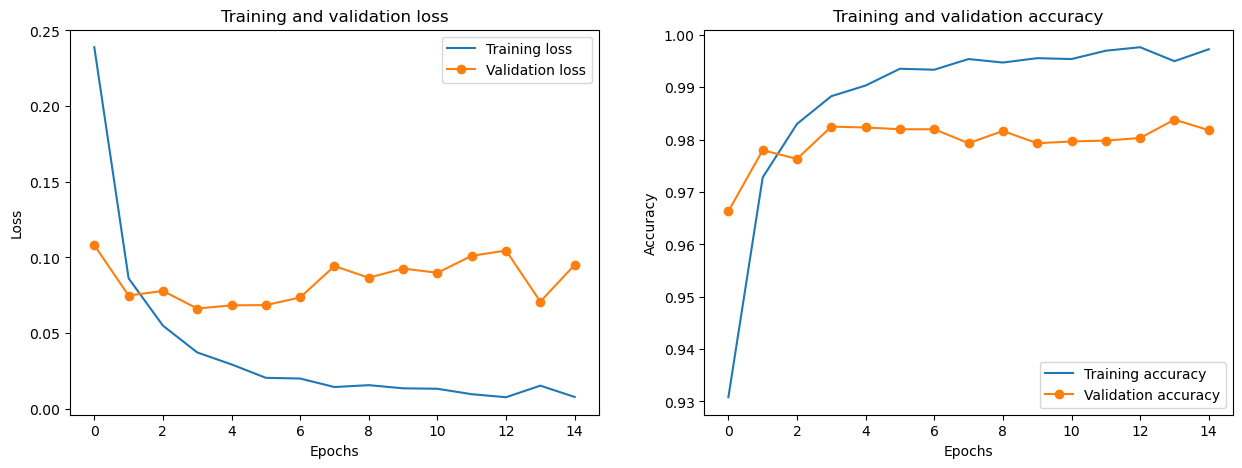

In [274]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
epochs_run = [i for i in range(epochs)]

ax1.plot(epochs_run, train_loss, label="Training loss")
ax1.plot(epochs_run, val_loss, label="Validation loss", marker="o")

ax1.set_title("Training and validation loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(epochs_run, train_acc, label="Training accuracy")
ax2.plot(epochs_run, val_acc, label="Validation accuracy", marker="o")

ax2.set_title("Training and validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()

#### 4.2.1. Model prediction

In [275]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.0761558935046196
Test accuracy: 0.9836000204086304


In [276]:
y_pred = model.predict(X_test)

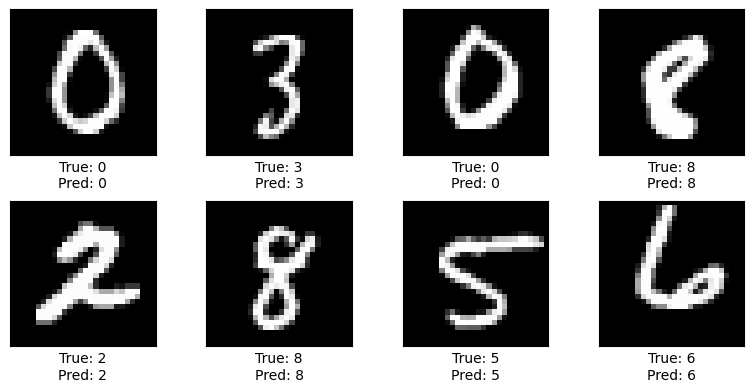

In [282]:
plot_data(X_test, np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))